In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.close()

In [0]:
data_url = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"

In [4]:
df = pd.read_csv(data_url, sep=",")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [0]:
x = df.households.values.reshape(-1, 1)
y = df.total_rooms.values.reshape(-1,1)

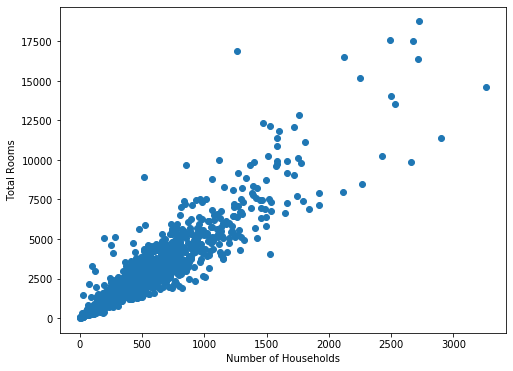

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(x[::10], y[::10])
plt.xlabel('Number of Households')
plt.ylabel('Total Rooms');

$$h(x) = x w + b$$

In [0]:
def get_params(shape):
    np.random.seed(7)
    params = {
    'W':tf.Variable(np.random.randn(*shape), dtype = tf.float32),
    'b':tf.Variable(np.zeros((1, shape[1])), dtype = tf.float32)
    }
    return params

In [0]:
params = get_params([x.shape[1], y.shape[1]])

In [9]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    result = sess.run(params)
    print(result)

{'W': array([[1.6905257]], dtype=float32), 'b': array([[0.]], dtype=float32)}


In [0]:
def linear(x, params):
    h = tf.add(tf.matmul(x, params['W']),params['b'])
    return h

In [0]:
def get_cost(x, y, model, params, lambd = 0):
    h= model(x, params)
    J = tf.math.reduce_mean((h-y)**2) + ((lambd/2)*tf.math.reduce_sum(params['W']**2)) 
    return J

In [0]:
def train(inp, out, model, epochs = 100, lr= 1e-3, lambd = 0):
    x = tf.placeholder(tf.float32, shape = (None, inp.shape[1]))
    y = tf.placeholder(tf.float32, shape = (None, out.shape[1]))
    params = get_params([x.shape[1], y.shape[1]])
    costs = []
    cost = get_cost(x, y, model, params, lambd)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session(config = config) as sess:
        sess.run(init)
        for epoch in range(epochs):
            c, _ = sess.run([cost, optimizer], feed_dict={x: inp, y:out})
            
            if epoch%(epochs//10) == 0:
                print('Cost at epoch ' + str(epoch), c)
            if epoch%5 == 0:
                costs.append(c)
                
        params = sess.run(params)
    
    return costs, params
        
    

In [18]:
costs, params = train(x, y, model = linear, lr= 1e-6)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Cost at epoch 0 5796791.0
Cost at epoch 10 738853.7
Cost at epoch 20 738853.7
Cost at epoch 30 738853.7
Cost at epoch 40 738853.7
Cost at epoch 50 738853.7
Cost at epoch 60 738853.7
Cost at epoch 70 738853.7
Cost at epoch 80 738853.7
Cost at epoch 90 738853.7


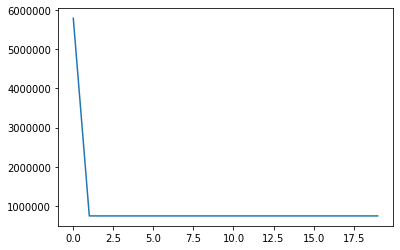

In [19]:
plt.plot(costs)

In [0]:
with tf.Session() as sess:
  inp = tf.constant(x, dtype = tf.float32)
  prediction = sess.run(linear(inp, params))


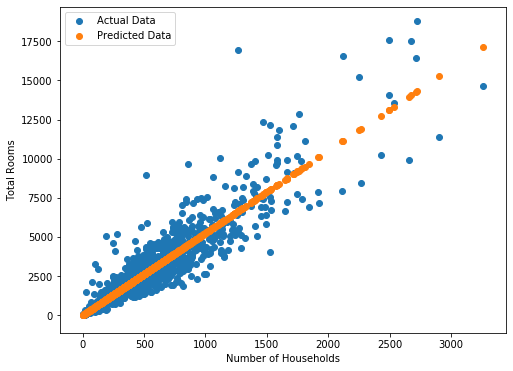

In [23]:
plt.figure(figsize = (8, 6))
plt.scatter(x[::10], y[::10], label = 'Actual Data')
plt.scatter(x[::10], prediction[::10], label = 'Predicted Data')
plt.legend()
plt.xlabel('Number of Households')
plt.ylabel('Total Rooms');